In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import geopandas as gpd
import json

import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import ticker
import scipy.signal as sig
import scipy.optimize as optimize
from shapely import LineString

import flim_processing as fp
import flim_analysis as fa
import flim_geometry as fg
import flim_chemistry as fc
import flim_ui as fui
from ivium import IviumFile

mass_particle_AC = 0.35e-6
radius_particle_AC = 454.5e-6
surface_area_AC = 2.6e-6
volume_AC = 39.46e-9
diff_OH = 5.270e-9
area_channel = 4e-3**2
nu_water = 1e-6
pixel_size = 9.09

In [2]:
data_folder = r"D:\[Code]\paper01\data"
figures_folder = r"D:\[Code]\paper01\figures"

"""FLIM data"""
time_data = fp.open_flim(
    os.path.join(data_folder, "time_p.npz"),
    property_modifications={"lifetime_phase": 1000, "value": 1000},
)

"""Features"""
time_features = fg.load_features(data_folder, "time_features.shp", "time_features.npz")

"""Open flim .json"""
with open(os.path.join(data_folder, "time.json"), "r") as file:
    time_info = json.load(file)
timestamps_flim = np.array(list(time_info["FLIMIMAGE"]["TIMESTAMPS in ms"].values()))
delta_t_flim = timestamps_flim[1] * 1e-3

"""Load Potential and Current data from ivium file"""
time_ivium = IviumFile()
time_ivium.set_path(os.path.join(data_folder, "time_ivium1428.csv"))
time_ivium.read_data_from_file()

"""Timestamps and frames"""
t_start = 30  # seconds
delta_t = 10  # seconds
t_eval = np.arange(t_start, 180, delta_t)
Fo_eval = (t_eval - t_start) * diff_OH / (2 * radius_particle_AC) ** 2

time_stamps = np.array([1000, 180, 240, 300, 360, 420, 480, 540, 600, 660])
flim_frames = fp.timestamp2frame_flim(t_eval, time_info, offset_flim=-5)[
    "flim_frames"
]

In [3]:
particle = [f for f in time_features if f.name == "particle"][0]
wall = [f for f in time_features if f.name == "wall"][0]
membrane = [f for f in time_features if f.name == "membrane"][0]
volume = [f for f in time_features if f.name == "volume"][0]

extent = fa.get_extent(time_data["value"][0], 9.09, 1e-3)
geom_extent = [
    0,
    time_data["intensity"][0].shape[1],
    0,
    time_data["intensity"][0].shape[0],
]

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


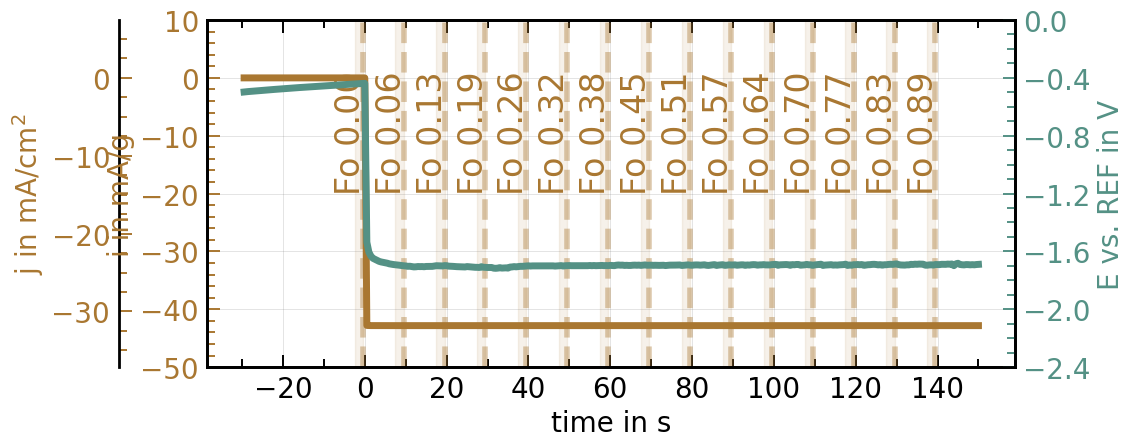

In [4]:
"""Color Map"""
cmap = plt.get_cmap("cmo.tarn")  # type:ignore
colors = cmap(np.linspace(0.25, 0.75, 2))

fig, ax = plt.subplots(figsize=(12, 5))

ax.set_ylabel(r"i in mA/g")
ax.set_xlabel("time in s")
ax_ = ax.twinx()
ax_.set_ylabel("E vs. REF in V")

ax.grid(alpha=0.3)
ax_.grid(alpha=0)
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax.yaxis.label.set_color(colors[0])
ax.tick_params(axis="y", which="both", colors=colors[0])


def current_specific2density(x):
    return x * surface_area_AC / mass_particle_AC * 1e3 / 1e4


def current_density2specifc(x):
    return x * surface_area_AC / mass_particle_AC


ax2 = ax.secondary_yaxis(
    -0.11, functions=(current_specific2density, current_density2specifc)
)
ax2.set_ylabel("j in mA/cm$^2$")
ax2.yaxis.label.set_color(colors[0])  # type: ignore
ax2.tick_params(axis="y", which="both", colors=colors[0])
ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))  # type: ignore
ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator(4))  # type: ignore

ax_.yaxis.label.set_color(colors[-1])
ax_.tick_params(axis="y", which="both", colors=colors[-1])


ax.plot(time_ivium.t - t_start, time_ivium.I / mass_particle_AC, color=colors[0])
ax_.plot(time_ivium.t - t_start, time_ivium.E, color=colors[-1])

ax.set_ylim(-50, 10.0)
ax_.set_ylim(-2.4, 0.0)
ax.yaxis.set_major_locator(ticker.LinearLocator(7))
ax_.yaxis.set_major_locator(ticker.LinearLocator(7))


for i_time, time_stamp in enumerate(t_eval):
    x = time_ivium.t[time_ivium.t < time_stamp][-1] - t_start
    i = time_ivium.t[time_ivium.t < time_stamp][-1]
    ymin = time_ivium.I.min() / mass_particle_AC
    ymax = time_ivium.I.max() / mass_particle_AC
    ax.axvline(x=x, color=colors[0], alpha=0.4, ls="--", lw=4)
    ax.axvspan(x - 2, x, color=colors[0], alpha=0.1)
    s = f"Fo {Fo_eval[i_time]:.2f}"
    y = -20
    ax.text(
        x=x + 1,
        y=y,
        s=s,
        rotation=90,
        horizontalalignment="right",
        verticalalignment="bottom",
        color=colors[0],
    )

fig.tight_layout()
fig.savefig(
    r"D:\[Code]\paper01\figures\time_EandI.png",
    dpi=100,
    transparent=True,
)
plt.show()

# Boundary Layer Calculations

In [5]:
ohminus = fc.ph2ohminus(time_data["value"])

In [6]:
distance_end_point = 200
number_rays = 360
pulling_bearing = 5

base_points = fa.get_points_along_line_number(
    particle.geometry.exterior, number_rays
)  # type:ignore
rays = fg.get_rays_of_sphere_like_base_points(
    base_points, pulling_bearing
)

for i_ray, ray in enumerate(rays):
    ray.set_end_point_image(time_data["intensity"][0])
    ray.set_end_point_volume(volume.geometry)
    ray.set_end_point(distance_end_point)

ray_lines = []
for ray in rays:
    line = LineString([ray.base_point, ray.end_point_image])
    ray_lines.append(line)

90.0 74.53531065934328
89.0 69.64389143681416
88.0 66.48200507615252
87.0 65.73002512482816
86.0 65.87697636724192
85.0 67.49965140427781
84.0 68.2211408088329
83.0 67.49464326786227
82.0 66.6488439515773
81.0 66.2768270800508
80.0 67.551527401702
79.0 70.54145899615747
78.0 73.50980772808254
77.0 75.96342132769257
76.0 77.21913937888655
75.0 75.91756460786718
74.0 72.4794063782922
73.0 68.57434324247703
72.0 64.80422465994394
71.0 61.39645668135648
70.0 58.645053018727594
69.0 56.761217904858654
68.0 55.742456293181306
67.0 55.16426787503792
66.0 55.19440874649331
65.0 55.67323438248695
64.0 55.632065706519654
63.0 55.74076695644993
62.0 55.22196442251044
61.0 53.08747316062579
60.0 50.01207873836415
59.0 46.01985518224842
58.0 41.90631935736678
57.0 38.947033022855805
56.0 37.57649455932034
55.0 37.18473953840862
54.0 38.11682632716048
53.0 39.65796043178034
52.0 40.63177962937357
51.0 41.446370600026796
50.0 41.86848606348036
49.0 40.79777746075382
48.0 38.76036997759451
47.0 38.021

In [7]:
chosen_ray_numbers = [-40, -5, 35, 72, 133, 175, 225, 268]
chosen_rays = []
for number in chosen_ray_numbers:
    if number < 0:
        number += 360 - 1
    chosen_rays.append(rays[number])

# Analysis at all times | 8 Rays

In [8]:
rolling_window = 11
fraction_limit = 0.3
min_pixel = 10
time_steps = 1
max_time = 200
ohminus_base = ohminus[10:70].mean(axis=0)

res0s = []
for ray in chosen_rays:
    res0 = ray.get_values_along_ray(
        ohminus_base, pixel_size=pixel_size, rolling_window=rolling_window
    )
    res0s.append(res0)

time_results = []
count = -1
for i_frame, (frame) in enumerate(time_data["value"]):
    if i_frame < flim_frames[0]:
        continue
    time_stamp = (i_frame - (flim_frames[0])) * delta_t_flim
    if (i_frame - flim_frames[0]) % time_steps != 0:
        continue
    if time_stamp > max_time:
        break
    count += 1

    mean = ohminus[i_frame - 2 : i_frame + 1].mean(axis=0)

    rays_to_analyse = chosen_rays
    ray_numbers_to_analyse = chosen_ray_numbers

    ray_results = []
    for i_ray, (ray_number, ray) in enumerate(
        zip(ray_numbers_to_analyse, rays_to_analyse)
    ):
        res = ray.get_values_along_ray(
            mean, pixel_size=pixel_size, rolling_window=rolling_window
        )
        delta_oh_minus = res["values"] - res0s[i_ray]["values"]
        surface_delta_oh_minus = delta_oh_minus[:5].mean()
        warnings.simplefilter("ignore")
        bulk_delta_oh_minus = delta_oh_minus[
            delta_oh_minus
            < (
                0.1 * (delta_oh_minus.min() + delta_oh_minus.max())
                + delta_oh_minus.min()
            )
        ].mean()
        warnings.warn("deprecated", DeprecationWarning)
        peak_delta_oh_minus = surface_delta_oh_minus

        if count == 0:
            m = -9999
            peak = 0
            delta = 0
            peak_loc = 0
            fit_window_end = 0
        else:
            """radius of particle as benchmark"""
            benchmark_id = res["ray"][res["ray"] < radius_particle_AC * 1e6].size

            """peak detection"""
            try:
                peaks, properties = sig.find_peaks(
                    delta_oh_minus[:benchmark_id],
                    height=delta_oh_minus.max() * 0.7,
                    prominence=1e-5,
                )
                peak = peaks[np.argmax(properties["prominences"])]

                peak_delta_oh_minus = properties["peak_heights"][
                    np.argmax(properties["prominences"])
                ]
            except:
                peak = 0
                peak_delta_oh_minus = surface_delta_oh_minus

            if surface_delta_oh_minus >= peak_delta_oh_minus:
                peak = 0
                peak_delta_oh_minus = surface_delta_oh_minus

            xs = (
                res["ray"] / radius_particle_AC * 1e-6
            )  # dimensionless with particle radius
            ys = delta_oh_minus / peak_delta_oh_minus  # dimensionless y
            peak_loc = xs[peak]
            fit_window_end = peak
            
            """linear fit + boundary layer thickness calculation"""
            try:
                indices_below_threshold = np.where(ys[peak:] < fraction_limit)[0]
                fit_window_end = (
                    indices_below_threshold[
                        (indices_below_threshold - peak) > min_pixel
                    ][0]
                    + peak
                )
                ps, _ = optimize.curve_fit(
                    fa.linear,
                    xs[peak:fit_window_end],
                    ys[peak:fit_window_end],
                    p0=[-1, 1],
                )
                m = ps[0]
                n = ps[1]
                delta = -1 / m + peak_loc

            except ValueError as e:
                m = -9999
                peak = 0
                delta = 0
                peak_loc = 0
                fit_window_end = 0
                continue

            except IndexError as e:
                m = -9999
                peak = 0
                delta = 0
                peak_loc = 0
                fit_window_end = 0
                continue

        results = pd.Series(
            {
                "i_ray": i_ray,
                "ray": ray_number,
                "image_angle": ray.angle,
                "time": time_stamp,
                "count_frame": count,
                "lifa_frame": i_frame,
                "peak_id": peak,
                "fit_window_end": fit_window_end,
                "peak": peak_loc,
                "m": m,
                "delta": delta,
                "surface_delta_oh_minus": surface_delta_oh_minus,
                "peak_delta_oh_minus": peak_delta_oh_minus,
                "bulk_delta_oh_minus": bulk_delta_oh_minus,
            }
        )
        ray_results.append(results)
    time_results.append(pd.DataFrame(ray_results))
data = pd.concat(time_results, ignore_index=True)
data["flow_angle"] = data.image_angle.apply(fa.angle_image2flow)
data["i_ray"] = data.i_ray.astype("int")
data["ray"] = data.ray.astype("int")
data["lifa_frame"] = data.lifa_frame.astype("int")
data["count_frame"] = data.count_frame.astype("int")
data["distance"] = data.delta.astype("float") * radius_particle_AC
data["sigma"] = np.sqrt(
    (
        (data.delta - fa.rollavg_convolve_circle(data.delta, 31))
        / fa.rollavg_convolve_circle(data.delta, 31)
    )
    ** 2
)
data["time"] = data.time.astype("float")
print(data.size)
data.to_csv(os.path.join(data_folder, "time_results_8rays.csv"))

44421


In [9]:
frame_index = 4
data.query(f"lifa_frame == {flim_frames[frame_index]}")

,i_ray,ray,image_angle,time,count_frame,lifa_frame,peak_id,fit_window_end,peak,m,delta,surface_delta_oh_minus,peak_delta_oh_minus,bulk_delta_oh_minus,flow_angle,distance,sigma
688,0,-40,129.297924,39.044,86,160,0.0,23.0,0.00,-1.850698,0.540337,0.000184,0.000184,-0.000023,-140.702076,0.000246,0.599195
689,1,-5,87.912050,39.044,86,160,15.0,41.0,0.30,-1.092351,1.215457,0.000089,0.000108,-0.000023,177.912050,0.000552,0.090061
690,2,35,37.184740,39.044,86,160,11.0,48.0,0.22,-0.954913,1.267216,0.000315,0.000376,0.000005,127.184740,0.000576,0.044227
691,3,72,6.522657,39.044,86,160,13.0,47.0,0.26,-0.860351,1.422317,0.000401,0.000538,-0.000051,96.522657,0.000646,0.069991
692,4,133,326.455749,39.044,86,160,0.0,61.0,0.00,-0.565854,1.767240,0.000404,0.000404,0.000005,56.455749,0.000803,0.370828
693,5,175,269.969125,39.044,86,160,7.0,50.0,0.14,-0.609999,1.779347,0.000125,0.000200,-0.000026,-0.030875,0.000809,0.395631
694,6,225,209.947438,39.044,86,160,8.0,45.0,0.16,-0.682525,1.625147,0.000095,0.000098,-0.000026,-60.052562,0.000739,0.227863
695,7,268,180.450119,39.044,86,160,0.0,36.0,0.00,-0.917304,1.090152,0.000191,0.000191,-0.000090,-89.549881,0.000495,0.170619


# Analysis at t = 40s (Frame 4) | All Rays

In [10]:
frame_index = 4
rolling_window = 11
fraction_limit = 0.3
min_pixel = 10
ohminus_base = ohminus[10:70].mean(axis=0)
ray_stepsize = 1

res0_all = []
for ray in rays[::ray_stepsize]:
    res0 = ray.get_values_along_ray(
        ohminus_base, pixel_size=pixel_size, rolling_window=rolling_window
    )
    res0_all.append(res0)

time_results = []

i_frame = flim_frames[frame_index]
frame = time_data["value"][i_frame]
time_stamp = (i_frame - (flim_frames[0])) * delta_t_flim
mean = ohminus[i_frame - 2 : i_frame + 1].mean(axis=0)

ray_results = []
for i_ray, (ray) in enumerate(rays[::ray_stepsize]):
    res = ray.get_values_along_ray(
        mean, pixel_size=pixel_size, rolling_window=rolling_window
    )
    delta_oh_minus = res["values"] - res0_all[i_ray]["values"]
    surface_delta_oh_minus = delta_oh_minus[:5].mean()
    warnings.simplefilter("ignore")
    bulk_delta_oh_minus = delta_oh_minus[
        delta_oh_minus
        < (0.1 * (delta_oh_minus.min() + delta_oh_minus.max()) + delta_oh_minus.min())
    ].mean()
    warnings.warn("deprecated", DeprecationWarning)
    peak_delta_oh_minus = surface_delta_oh_minus

    """radius of particle as benchmark"""
    benchmark_id = res["ray"][res["ray"] < radius_particle_AC * 1e6 * 0.5].size

    """peak detection"""
    try:
        peaks, properties = sig.find_peaks(
            delta_oh_minus[:benchmark_id],
            height=delta_oh_minus.max() * 0.7,
            prominence=1e-5,
        )
        peak = peaks[np.argmax(properties["prominences"])]

        peak_delta_oh_minus = properties["peak_heights"][
            np.argmax(properties["prominences"])
        ]
    except:
        peak = 0
        peak_delta_oh_minus = surface_delta_oh_minus

    if surface_delta_oh_minus >= peak_delta_oh_minus * 1.2:
        peak = 0
        peak_delta_oh_minus = surface_delta_oh_minus

    xs = res["ray"] / radius_particle_AC * 1e-6  # dimensionless with particle radius
    ys = delta_oh_minus / peak_delta_oh_minus  # dimensionless y
    peak_loc = xs[peak]

    """linear fit + boundary layer thickness calculation"""
    try:
        indices_below_threshold = np.where(ys[peak:] < fraction_limit)[0]
        fit_window_end = (
            indices_below_threshold[(indices_below_threshold - peak) > min_pixel][0]
            + peak
        )

        ps, _ = optimize.curve_fit(
            fa.linear,
            xs[peak:fit_window_end],
            ys[peak:fit_window_end],
            p0=[-1, 1],
        )
        m = ps[0]
        n = ps[0]
        delta = -1 / m + peak_loc

    except ValueError as e:
        m = -9999
        peak = 0
        delta = 0
        peak_loc = 0
        fit_window_end = 0
        continue

    results = pd.Series(
        {
            "i_ray": i_ray,
            "image_angle": ray.angle,
            "time": time_stamp,
            "count_frame": count,
            "lifa_frame": i_frame,
            "peak_id": peak,
            "fit_window_end": fit_window_end,
            "peak": peak_loc,
            "m": m,
            "delta": delta,
            "surface_delta_oh_minus": surface_delta_oh_minus,
            "peak_delta_oh_minus": peak_delta_oh_minus,
            "bulk_delta_oh_minus": bulk_delta_oh_minus,
        }
    )
    ray_results.append(results)
data_all = pd.DataFrame(ray_results)
data_all["flow_angle"] = data_all.image_angle.apply(fa.angle_image2flow)
data_all["i_ray"] = data_all.i_ray.astype("int")
data_all["lifa_frame"] = data_all.lifa_frame.astype("int")
data_all["count_frame"] = data_all.count_frame.astype("int")
data_all["distance"] = (
    data_all.delta.astype("float") * radius_particle_AC
)
data_all["sigma"] = np.sqrt(((data_all.delta - fa.rollavg_convolve_circle(data_all.delta, 31))/ fa.rollavg_convolve_circle(data_all.delta, 31))**2)
data_all["time"] = data_all.time.astype("float")
print(data_all.shape)
data_all.to_csv(os.path.join(data_folder, "time_results_40s_allrays.csv"))

(360, 16)


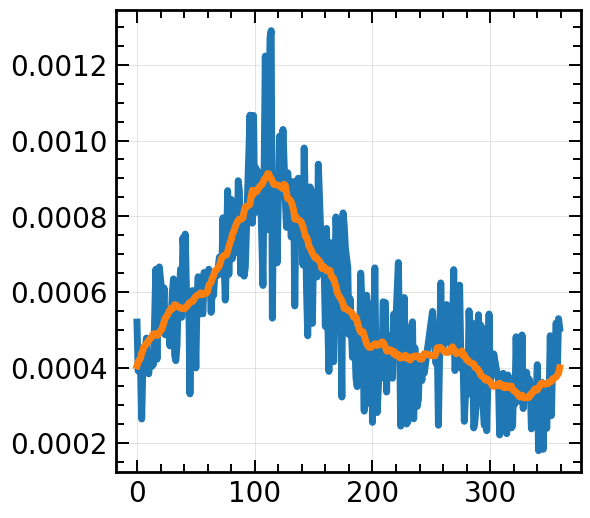

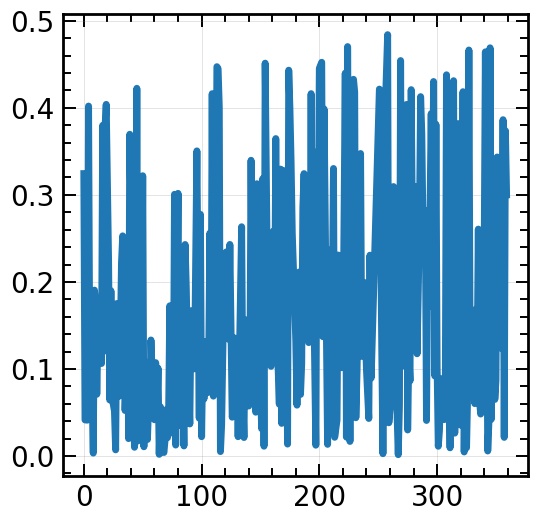

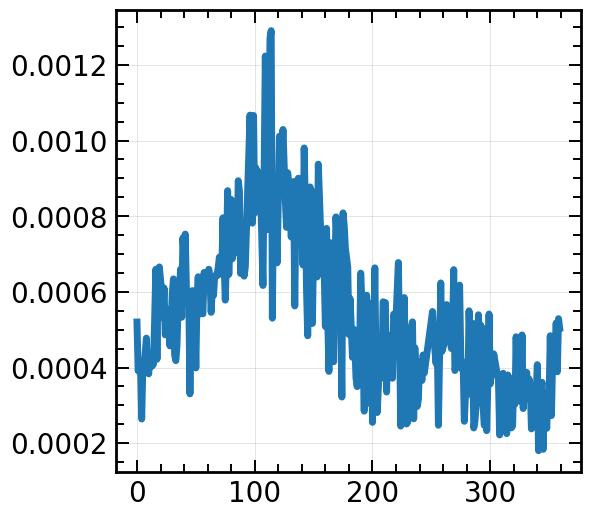

In [11]:
d = data_all.query("sigma < 0.5")
# d = data_all.copy()

plt.plot(d.i_ray, d.distance)
plt.plot(d.i_ray, fa.rollavg_convolve_circle(d.distance, 31))
plt.show()
plt.plot(d.i_ray, d.sigma)
plt.show()

d_filtered = d.query("sigma < 0.5")
plt.plot(d_filtered.i_ray, d_filtered.delta * radius_particle_AC)